In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


In [2]:
df = pd.read_csv('../records/integration.csv')
df.drop('Type',axis = 1,inplace=True)
# df.sort_values(axis = 0, ascending=False,by='result',inplace=True)
df.drop('Winglets', axis=1,inplace=True)
df.head(10)

,Weight,Elevators,theta,rou,result
0,10,50,25,50,34.9
1,10,55,25,50,34.9
2,10,0,35,50,12.0
3,10,5,35,50,13.4
4,10,10,35,50,14.9
5,10,15,35,50,16.6
6,10,20,35,50,18.7
7,10,25,35,50,20.7
8,10,30,35,50,22.8
9,10,35,35,50,24.5


In [4]:
df.info

<bound method DataFrame.info of        Weight  Elevators  theta  rou  result
10347       6         30     41  100    48.9
9633        6         28     41  100    48.9
10299       0         30     38  105    48.9
10368       9         30     41  100    48.8
9585        0         28     38  105    48.8
...       ...        ...    ...  ...     ...
23155       0         66     41   95     0.0
23153       0         66     41   85     0.0
8345       27         24     38  100     0.0
258        55         30     40   90     0.0
1501        0         25     55   55     0.0

[24735 rows x 5 columns]>

In [3]:
# 去除0
newdf = df.drop(index = df.result[df.result == 0.0].index)
from sklearn.utils import shuffle
newdf = shuffle(newdf)

newdf.head()

,Weight,Elevators,theta,rou,result
16339,48,46,35,105,44.0
14650,9,42,41,95,42.8
13051,87,36,38,110,9.8
896,50,15,50,85,41.8
24733,100,71,41,110,46.3


In [2]:
newdf.to_csv('../records/initial.csv')

NameError: name 'newdf' is not defined

In [40]:
nows = newdf[['Weight','result']]
nows.set_index('Weight',inplace=True)
nows.head()

,result
Weight,
15,17.7
21,7.5
20,39.9
85,43.8
75,6.7


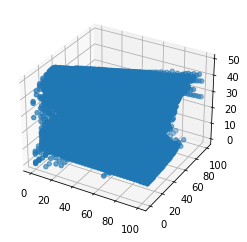

In [41]:
#定义坐标轴
fig = plt.figure()

ax1 = plt.axes(projection='3d')
#ax = fig.add_subplot(111,projection='3d')  #这种方法也可以画多个子图
ax1.scatter3D(df['Weight'],df['Elevators'],df['result'],cmap='Blues')

# plt.show()
# plt.savefig("../check.fig")


In [3]:
newdf = pd.read_csv('../records/initial.csv')

In [4]:
# 划分训练集和测试集
train = newdf[:5000]
test = newdf[5000:]
X_train = train[['Weight','Elevators','theta','rou']]
X_train = X_train[0:]
Y_train = train[['result']]
Y_train.head()

X_train = np.array(X_train)
Y_train = np.array(Y_train)
# print(Y_train)
X_test = test[['Weight','Elevators','theta','rou']]
Y_test = test[['result']]
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

noise = 0.01
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2,n_restarts_optimizer=10)

gpr.fit(X_train, Y_train)
# print(X_train)

D:\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=0.0001, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [7]:
# 计算后验预测分布的均值向量与协方差矩阵
mu_s = gpr.predict(X_test[0:6], return_cov=False)
print(mu_s)
# 获得最优核函数参数
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
print(l,sigma_f)
# 与前面手写的结果比对
# assert(np.isclose(l_opt, l))
# assert(np.isclose(sigma_f_opt, sigma_f))

# 绘制结果
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)


[[ 4.77829802]
 [ 6.07479529]
 [18.71686493]
 [44.3404513 ]
 [44.18003316]
 [ 5.35597657]]
4.4530423002625685 20.435959263546604


In [9]:
# Y_test[0:6]
import joblib
joblib.dump(gpr, './rawGP_model.pkl')


['./rawGP_model.pkl']

以上是直接学习 5000用了快20分钟 下面试试标准化

In [10]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
print('mean:', scaler.mean_)
print('scale:', scaler.scale_)

mean: [50.5128 39.4688 40.4618 96.096 ]
scale: [29.58750135 17.45477088  5.24577361 13.08009113]


In [11]:
X_scaled = scaler.transform(X_train)
X_scaled

array([[-0.08492775,  0.3741785 , -1.04118104,  0.6807292 ],
       [-1.4030519 ,  0.14501479,  0.10259688, -0.08379147],
       [ 1.23319639, -0.19873077, -0.46929208,  1.06298954],
       ...,
       [ 0.15165863,  1.63457889, -1.04118104, -0.4660518 ],
       [ 0.6248314 , -0.77164003, -1.04118104,  1.06298954],
       [ 0.6248314 ,  0.48876035,  0.10259688, -0.08379147]])

In [12]:
X_scaled.std(axis=0)

array([1., 1., 1., 1.])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(), gpr)



In [15]:
pipe.fit(X_train, Y_train)

D:\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussianprocessregressor',
                 GaussianProcessRegressor(alpha=0.0001,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=10))])

In [27]:
mu_s, cov = pipe.predict(X_test[0:2], return_cov=True)
print(mu_s,cov)
# joblib.dump(pipe, './pipe.pkl')

[[9.87028761]
 [5.89108441]] [[1.98190877 0.16064493]
 [0.16064493 6.5494202 ]]


In [20]:
Y_test[0:6]

array([[ 9.7],
       [ 6. ],
       [15. ],
       [45. ],
       [46.9],
       [ 5.9]])

In [24]:
gpr = joblib.load('./rawGP_model.pkl')
mu_s = gpr.predict(X_test[0:6], return_cov=False)
print(mu_s)

[[ 4.77829802]
 [ 6.07479529]
 [18.71686493]
 [44.3404513 ]
 [44.18003316]
 [ 5.35597657]]


In [28]:
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])
print(l,sigma_f)

4.4530423002625685 20.435959263546604
